In [292]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [232]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal']
data.columns, data.shape

(Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
        'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
        'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
        'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
        'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
        'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
        'success_rate'],
       dtype='object'),
 (8421, 39))

In [234]:
df = data
if 'Unnamed: 0' in df.columns or 'succsess' in df.columns:
    df = data.drop(columns=['Unnamed: 0', 'succsess'])
df['site'] = df['site'].fillna('')
df.shape

(8421, 37)

In [235]:
print(df[df['is_site'] == 1]['success_rate'].median(), df[df['is_site'] == 1]['success_rate'].mean())
print(df[df['is_site'] == 0]['success_rate'].median(), df[df['is_site'] == 0]['success_rate'].mean())

0.1360499272594055 9.154625363297395
0.0154 2.175598071346449


In [236]:
df.isnull().sum()

URL             0
pled            0
goal            0
date            0
period          0
status          0
text_am         0
n_img           0
n_vid           0
n_pled_t        0
min_pled_t      0
max_pled_t      0
mean_pled_t     0
step_pled_t     0
cr_time         0
backed          0
created         0
site            0
rpg             0
platformer      0
shooter         0
fighting        0
survival        0
horror          0
strategy        0
arcade          0
simulator       0
mmo             0
indie           0
action          0
quest           0
adventure       0
mgp             0
cont            0
curr            0
is_site         0
success_rate    0
dtype: int64

In [254]:
numeric_columns = ['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
#   'min_pled_t',
#   'max_pled_t',
#   'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
genres = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure']
target_column = 'success_rate'
numeric_columns, traget_column

(['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont'],
 'success_rate')

In [266]:
def draw_boxplots(df, numeric_columns):
    fig, axes = plt.subplots(4, 4, figsize=(18, 40))
    for i in range(4):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].boxplot(df[numeric_columns[4 * i + j]], labels=[numeric_columns[4 * i + j]])       

In [270]:
def draw_hist(df, numeric_columns, bar_type=None):
    bar_type = 'bar' if bar_type == None else bar_type
    fig, axes = plt.subplots(4, 4, figsize=(18, 20))
    for i in range(4):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].hist(df[numeric_columns[4 * i + j]], label=numeric_columns[4 * i + j], histtype=bar_type)
            axes[i,j].legend()

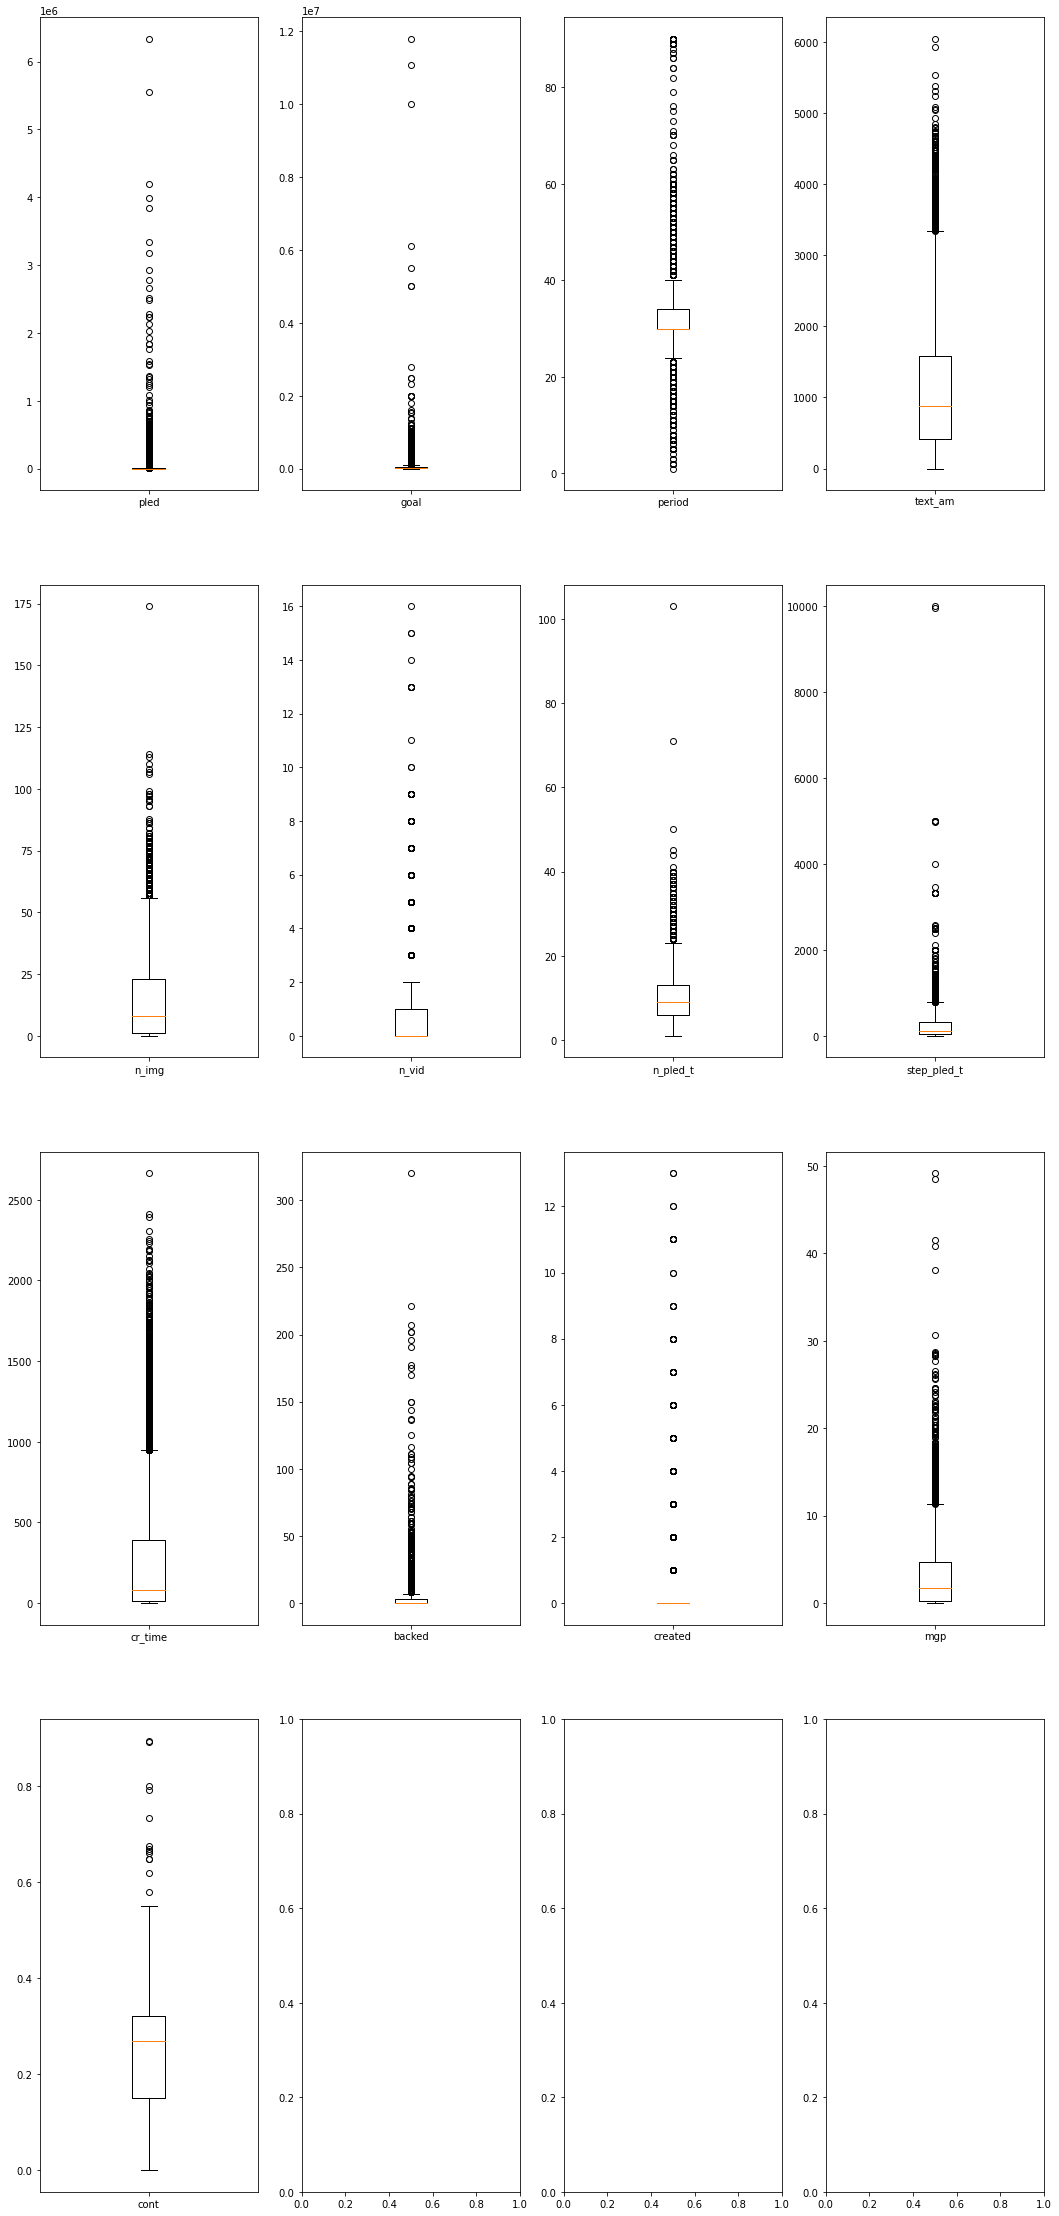

In [271]:
draw_boxplots(df, numeric_columns)

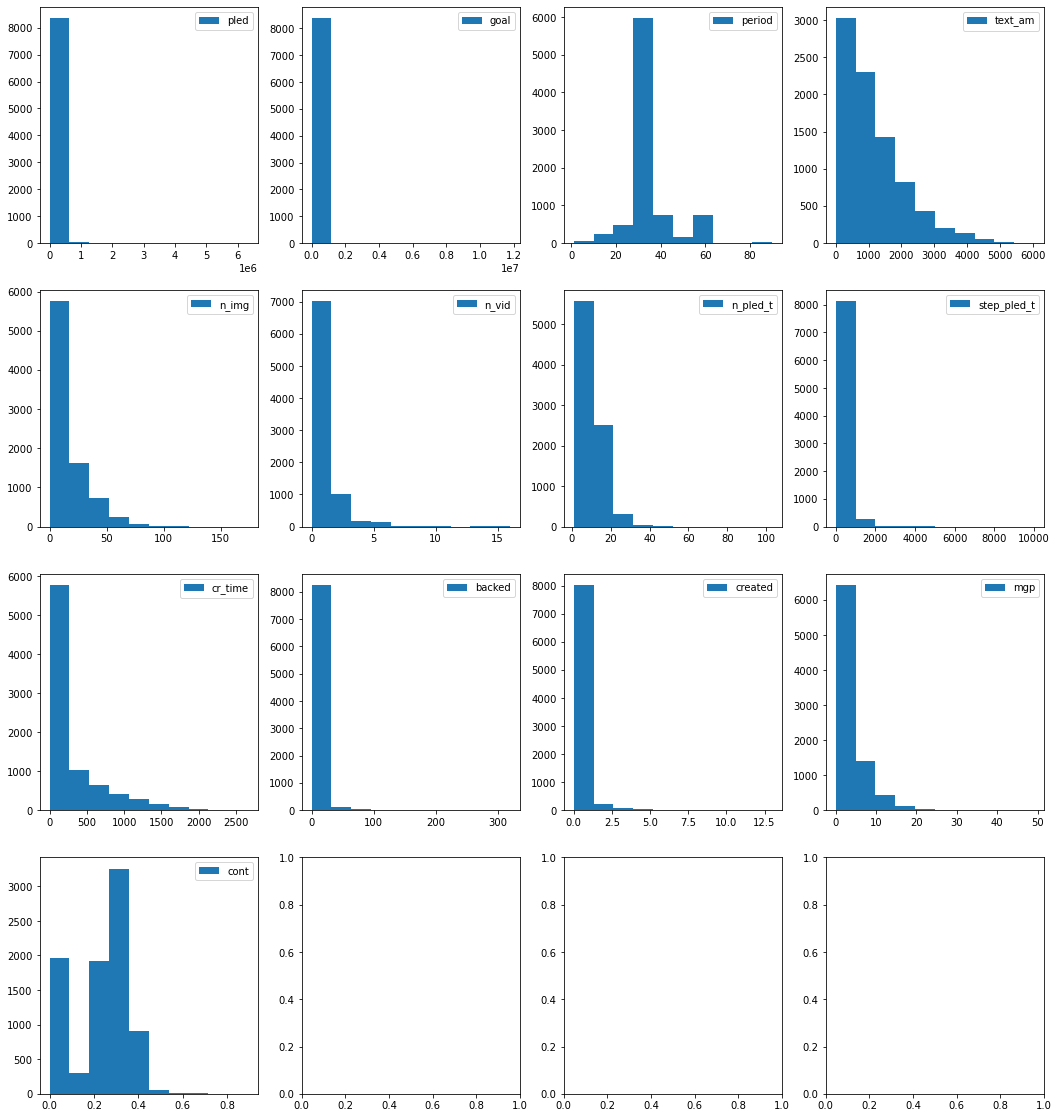

In [274]:
draw_hist(df, numeric_columns, 'bar')

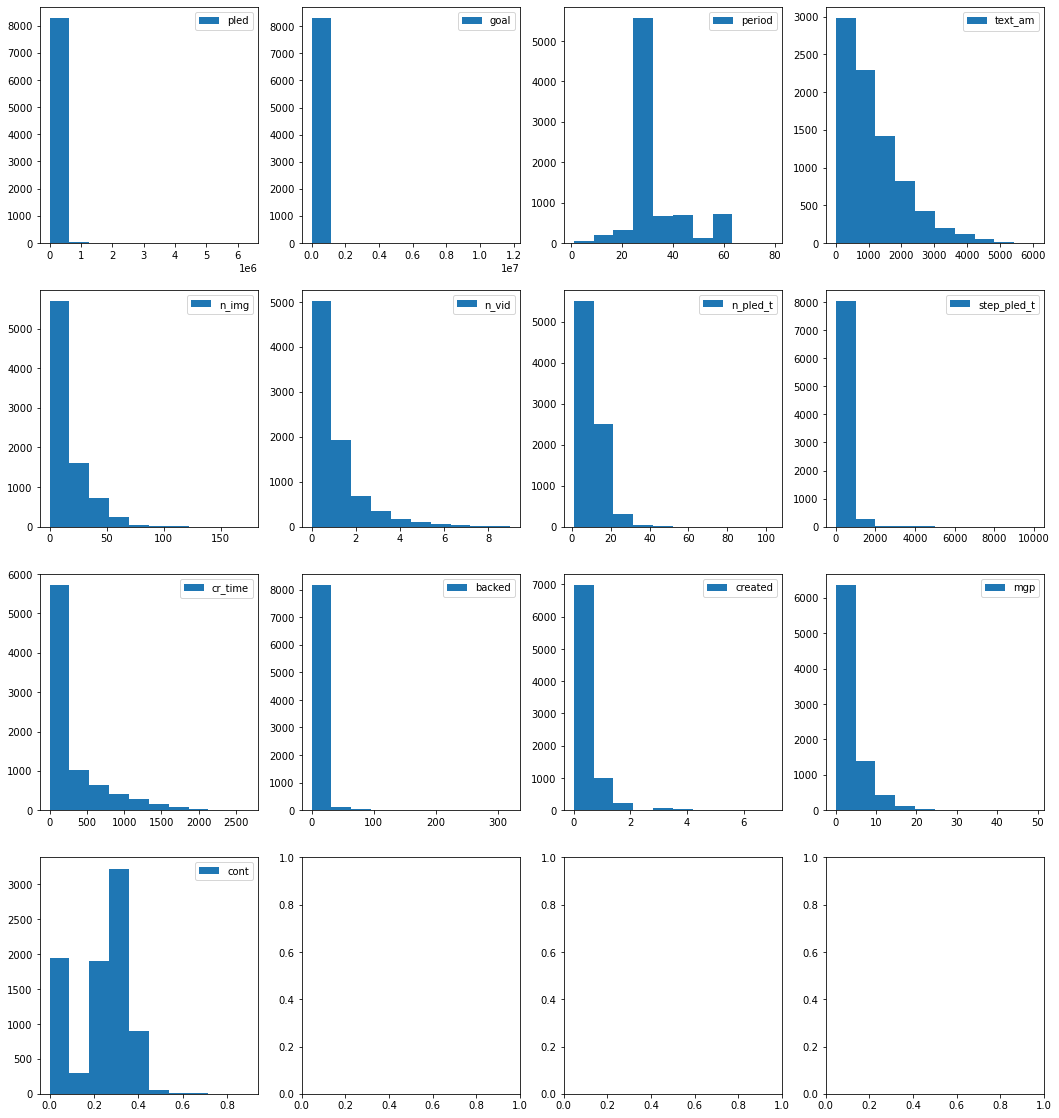

In [332]:
# Remove emissions
df = data
df = df[df['goal'] > 5]
df = df[df['created'] < 7.5]
df = df[df['period'] < 80]
df = df[df['n_vid'] < 10]
draw_hist(df, numeric_columns, 'bar')

In [333]:
df.shape

(8334, 39)

In [379]:
model = LinearRegression()
scaler = StandardScaler()

X_train, x_test, y_train, y_test = train_test_split(df[numeric_columns[2:] + genres], df[target_column], train_size=0.8)

scaler.fit(X_train)
trian_inp = scaler.transform(X_train)

In [380]:
model.fit(trian_inp, y_train)

preds = model.predict(trian_inp)

mean_squared_error(preds, y_train)

80.1081216841766

In [381]:
test_inp = scaler.transform(x_test)
preds = model.predict(test_inp)

mean_squared_error(preds, y_test)

5.939357366762522

In [382]:
{df[numeric_columns[2:] + genres].columns[i]: model.coef_[i] for i in range(len(model.coef_))}

{'period': -0.10228020721310485,
 'text_am': -0.02385175424302932,
 'n_img': -0.18132592707925982,
 'n_vid': 0.3854391949512779,
 'n_pled_t': -0.22633069627796984,
 'step_pled_t': -0.08926903376908313,
 'cr_time': 0.4732287460996631,
 'backed': -0.03796510486702756,
 'created': -0.053796685360117454,
 'mgp': 0.4444227813947343,
 'cont': 0.08319493118706678,
 'rpg': 0.17217936647477108,
 'platformer': 0.23605914968991362,
 'shooter': -0.042410291841824224,
 'fighting': -0.11829650392668048,
 'survival': -0.1268828482489863,
 'horror': 0.17008261964281202,
 'strategy': -0.07378320102793086,
 'arcade': 0.004810099952396511,
 'simulator': 0.10595261118640514,
 'mmo': -0.07128838825643406,
 'indie': -0.03683877430348087,
 'action': -0.1448489846552412,
 'quest': 0.13408408692163531,
 'adventure': 0.013070986164327357}

In [359]:
df[numeric_columns[2:] + genres + [target_column]].corr()['success_rate']

period         -0.017947
text_am         0.024996
n_img           0.038489
n_vid           0.057008
n_pled_t        0.017904
step_pled_t    -0.012758
cr_time         0.057100
backed          0.024073
created         0.021075
mgp             0.045577
cont            0.032544
rpg             0.024695
platformer      0.025250
shooter        -0.009487
fighting       -0.003812
survival       -0.008431
horror          0.018719
strategy       -0.007977
arcade         -0.000577
simulator       0.010147
mmo            -0.007000
indie           0.013491
action         -0.002751
quest           0.023692
adventure       0.018422
success_rate    1.000000
Name: success_rate, dtype: float64

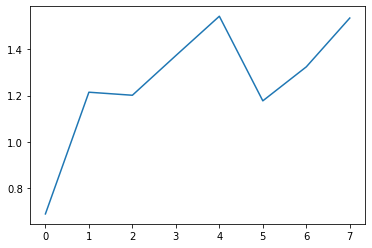

In [362]:
ys = []
for i in range(8):
    ys.append(df[df['created'] == i]['success_rate'].mean())
plt.plot(np.arange(8), ys)

In [364]:
df['cr_time'].value_counts()

1       217
0       202
2       200
3       188
4       167
       ... 
1669      1
1022      1
563       1
514       1
703       1
Name: cr_time, Length: 1377, dtype: int64

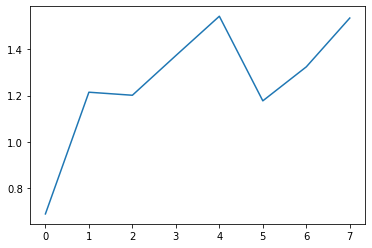

In [383]:
ys = []
for i in range(8):
    ys.append(df[df['created'] == i]['success_rate'].mean())
plt.plot(np.arange(8), ys)

In [384]:
df.describe()

,Unnamed: 0,pled,goal,period,text_am,n_img,n_vid,n_pled_t,min_pled_t,max_pled_t,...,mmo,indie,action,quest,adventure,mgp,cont,succsess,is_site,success_rate
count,8334.000000,8.334000e+03,8.334000e+03,8334.000000,8334.000000,8334.000000,8334.000000,8334.000000,8334.000000,8334.000000,...,8334.000000,8334.000000,8334.000000,8334.000000,8334.000000,8334.000000,8334.000000,8334.000000,8334.000000,8334.000000
mean,4342.375930,2.326118e+04,5.520756e+04,33.525078,1129.225942,14.366691,0.742741,10.054476,11.620628,2572.389360,...,0.067555,0.241181,0.264339,0.125990,0.252220,3.224531,0.224893,0.238901,0.706263,0.777305
std,2500.561966,1.733014e+05,2.748420e+05,10.186690,912.834684,16.595821,1.264704,5.914297,173.415098,3339.365591,...,0.250995,0.427825,0.441007,0.331858,0.434313,4.053161,0.137463,0.426438,0.455500,8.115077
min,1.000000,0.000000e+00,7.910000e+00,1.000000,0.000000,0.000000,0.000000,1.000000,0.580000,0.720000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2173.250000,6.705000e+01,3.661545e+03,30.000000,418.000000,1.000000,0.000000,6.000000,1.000000,200.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.241630,0.151445,0.000000,0.000000,0.008621
50%,4358.500000,7.685000e+02,1.000000e+04,30.000000,881.000000,8.000000,0.000000,9.000000,4.285000,1000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.792527,0.269012,0.000000,1.000000,0.078991
75%,6494.750000,6.374000e+03,3.846312e+04,33.000000,1590.750000,23.000000,1.000000,13.000000,6.220000,4581.165000,...,0.000000,0.000000,1.000000,0.000000,1.000000,4.698903,0.322285,0.000000,1.000000,0.660695
max,8666.000000,6.333295e+06,1.179675e+07,79.000000,6042.000000,174.000000,9.000000,103.000000,7420.910000,10000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,49.141376,0.894847,1.000000,1.000000,545.733333
